# Bootstrapping

Bootstrapping at its most basic seeks to understand the finite sample properties of an estimator by repeatedly creating finite samples from the data you have, estimating what you want to estimate, and examining the distribution of that estimator. 

In class I noticed some confusion regarding the residual bootstrap, so I will go over an example of that here. 

## The residual bootstrap
Consider a mother FE model where we want to examine the effect of an intervention on infant birth weight. The causal model we have in mind is that, conditional on mother fixed effects, exposure to say pollution in utero is random. Thus our estimating equation is:

$$y_{ijt} = \tau pollution_{it} + \lambda_i + \varepsilon_{ijt}$$

The idea for the residual bootstrap is to:

1. Run OLS $y_{ijt} = \tau pollution_{it} + e_{ijt}$
2. Calculat errors $e'= y_{ijt} - \widehat{\tau} pollution_{it}$
3. Resample from the vector of errors $e'$ to get a new vector of errors $\tilde{e'}$
4. Construct $y' = \widehat{\tau}pollution_{it} + \tilde{e'}$
5. Repeat.

Now let's assume our exclusion restriction does **not** hold, and that estimating this model will yield a $\widehat{\tau}$ such that $E(\widehat{\tau})\neq \tau$. Why is it still okay to resample the residuals?

Because of the properties of agnostic regression! Even if $E(P\varepsilon)\neq0$, OLS mechanically will make $E(Pe) = 0$. So bias does _not_ imply that our observed errors are correlated with X.


# Linear approximations

Implicit code review of: [linear-non-linear.ipynb](https://github.com/ligonteaching/ARE212_Materials/blob/master/linear-non-linear.ipynb)

We know that regression is the best linear approximator of the potentially non-linear conditional expectation function, $E(y|X)$. Linear regression is linear in _parameters_, but we can combine non-linear transformations of the explanatory variables to predict some pretty non-linear stuff! For example, the function $y = a + bx + cx^2$ is linear in $(a, b, c)$, but the linear combination of terms clearly returns something very non-linear.

Sticking with the polynomial case, by adding more and more terms we can approximate arbitrarily complex non-linear functions. But how do we know what the $(a, b, c, \ldots)$ should be? Easy: regression. We just create a regression function with $K$ covariates, which are $(1, x, x^2, x^3, \ldots, x^K)$, and estimate the $\beta$'s for each one.

First, let's create a non-linear function we want to approximate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def trueFunc(x):
    y = np.sin(x**2-2) + 1
    return y

Text(0.5, 1.0, 'True function F on [0,5]')

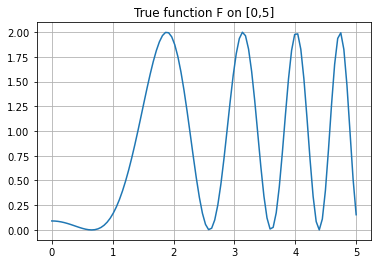

In [6]:
domain = np.linspace(0, 5, 100) # 100 from 0 to 5

fig, ax = plt.subplots()
plt.plot(domain, [trueFunc(x) for x in domain])

plt.grid()
plt.title("True function F on [0,5]")

In data we might think that we observe draws of X and y from this true function, but there is also noise in the data. So let's simulate that.

In [7]:
def noisyData_DGP(N, f, domain, std_errors=0.3):
    # pass in f, and domain to make as general as possible
    # domain should take the form (minim, maxim)
    X = np.linspace(domain[0], domain[1], N)
    y = [f(x) for x in X] + np.random.normal(scale=std_errors, size = N)
    return (X, y)  

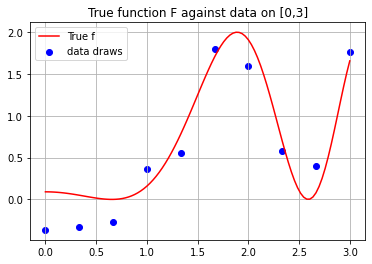

In [8]:
minn = 0
maxx = 3
N = 10

data = np.linspace(minn, maxx, 100) # 100 points
sim_data = noisyData_DGP(N, trueFunc, (minn, maxx)) # 10 points

fig, ax = plt.subplots()
plt.plot(data, [trueFunc(x) for x in data], color = 'red', label = 'True f')
plt.scatter(sim_data[0], sim_data[1], color = 'blue', label = 'data draws')

plt.grid()
plt.title("True function F against data on [0,3]")
plt.legend()

## Polynomial approximation

Now we're going to see how well we can approximate this function with different numbers of polynomials, K. Note that K=1 will have 2 terms, an intercept and x.

In [9]:
def fhat_polynomial(x, data, K):
    # first make the polynomials
    # data = data used to estimate the betas
    # x = observations for which I want to predict yhat(x)
    X, y = data
    y = y.reshape((-1,1)) # reshape from (N,) to (N,1)
    if K > 0:
        Xvec = np.c_[[X**k for k in range(K)]].T
    else: Xvec = (X**0).reshape((-1,1)) # N x 1 vector of ones 
    # regress!
    betas = np.linalg.lstsq(Xvec, y, rcond=None)[0]
    # now predict at x
    if K > 0:
        Xvec_pred = np.c_[[x**k for k in range(K)]].T
    else: Xvec_pred = (x**0).reshape((-1,1))
        
    return Xvec_pred@betas # yhat

(-0.5, 3.0)

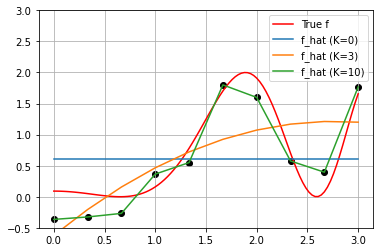

In [10]:
fig, ax = plt.subplots()

plt.plot(data, [trueFunc(x) for x in data], color = 'red', label = 'True f')
plt.scatter(sim_data[0], sim_data[1], color = 'black')

for k in [0, 3, 10]:
    plt.plot(sim_data[0], 
             fhat_polynomial(sim_data[0], sim_data, k),
             label = f'f_hat (K={k})')

plt.grid()
plt.legend()
ax.set_ylim([-0.5, 3])

The above graph really only interpolates a line between our yhats. So to get a better sense of what these functions look like, I am going to plot a bunch of yhats for new data between min - 1 and max + 1.

Sampling error: the distance between my data and the true line.
Approximation error: the distance between true f and f_hat (difference between the red line and the orange line)

(-3.0, 5.0)

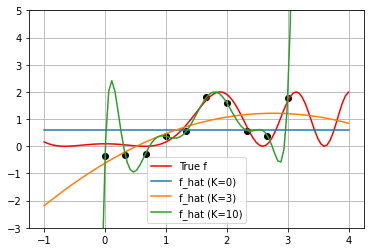

In [11]:
fig, ax = plt.subplots()

plotdata = np.linspace(minn - 1, maxx + 1, 100)

plt.plot(plotdata, [trueFunc(x) for x in plotdata], color = 'red', label = 'True f')
plt.scatter(sim_data[0], sim_data[1], color = 'black')

for k in [0, 3, 10]:
    plt.plot(plotdata, 
             fhat_polynomial(plotdata , sim_data, k),
             label = f'f_hat (K={k})')

plt.grid()
plt.legend()
ax.set_ylim([-3, 5])

There's a lot to dislike about this graph.
1. The green line hits every single data point. This is because with K = N approximating functions, we can exactly fit the data by solving the linear system of equations. But out goal is not to exactly fit the data, because we know that the data is partially noise. So we are literally fitting noise. This is the problem of **overfitting** in machine learning- if we are overly good at matching the idiosyncratic noise in our current data, extrapolating to new data may not work well because the noise in new observations is inherently different. 
2. The tails are very poorly behaved. This is known as Runge's phenomenon- high order polynomials will have insane peaks (like between the last two data points) and the ends may go off to inifinity since there is no more data there to discipline the function.